## Airline Delay Analysis

In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# Define the directory path
output_dir = Path("outputs/map_reduce/output")

# Define sub-directory names
sub_dirs = ["CarrierDelay", "NASDelay", "WeatherDelay", "LateAircraftDelay", "SecurityDelay"]

### Queries Outputs using MapReduce

In [3]:
# Function to process each sub-directory
def process_subdir(delay_type):
    delay_dir = output_dir / delay_type
    for i in range(5): 
        sub_dir = delay_dir / str(i) / "output"
        hadoop_files = list(sub_dir.glob("*hadoop*"))
        if hadoop_files:
            print(f"{delay_type} - Iteration No: {i}")
            dfs = []
            for file in hadoop_files:
                df = pd.read_csv(file, delimiter=',', names=['Year', delay_type], na_values='\\N')
                dfs.append(df)
 
            aggregated_df = pd.concat(dfs, ignore_index=True, axis=0)
            aggregated_df = aggregated_df.dropna(subset=['Year'])
            aggregated_df['Year'] = aggregated_df['Year'].astype(int)
            aggregated_df = aggregated_df.sort_values(by='Year', ascending=False)
            print(aggregated_df)
            print()

In [4]:
# Process each sub-directory
for subdir in sub_dirs:
    process_subdir(subdir)

CarrierDelay - Iteration No: 0
   Year  CarrierDelay
8  2010     21.893102
1  2009     28.330586
7  2008     28.883470
6  2007     19.850007
5  2006     30.453296
4  2005     28.019776
0  2004     43.644594
3  2003     24.557550

CarrierDelay - Iteration No: 1
   Year  CarrierDelay
8  2010     21.893102
1  2009     28.330586
7  2008     28.883470
6  2007     19.850007
5  2006     30.453296
4  2005     28.019776
0  2004     43.644594
3  2003     24.557550

CarrierDelay - Iteration No: 2
   Year  CarrierDelay
6  2010     21.893102
8  2009     28.330586
5  2008     28.883470
4  2007     19.850007
3  2006     30.453296
2  2005     28.019776
7  2004     43.644594
1  2003     24.557550

CarrierDelay - Iteration No: 3
   Year  CarrierDelay
6  2010     21.893102
8  2009     28.330586
5  2008     28.883470
4  2007     19.850007
3  2006     30.453296
2  2005     28.019776
7  2004     43.644594
1  2003     24.557550

CarrierDelay - Iteration No: 4
   Year  CarrierDelay
6  2010     21.893102
8  20

### Queries Outputs using Spark

In [5]:
output_dir_spark = Path("outputs/spark/output")

In [6]:
# Function to process each sub-directory
def process_iteration(iteration_dir):
    for delay_dir in sub_dirs:
        delay_path = iteration_dir / delay_dir
        csv_files = list(delay_path.glob("*.csv"))
        if csv_files:
            print(f"{delay_dir} - Iteration No: {iteration_dir.name}")
            for file in csv_files:
                df = pd.read_csv(file)
                df = df.sort_values(by='Year', ascending=False)
                print(df)
            print()

In [7]:
# Iterate through each iteration sub-directory
for i in range(5):  
    iteration_dir = output_dir_spark / str(i)
    if iteration_dir.exists():
        process_iteration(iteration_dir)

CarrierDelay - Iteration No: 0
   Year  CarrierDelay_Percent
7  2010             21.893102
6  2009             28.330586
5  2008             28.883470
4  2007             19.850007
3  2006             30.453296
2  2005             28.019776
1  2004             43.644594
0  2003             24.557550

NASDelay - Iteration No: 0
   Year  NASDelay_Percent
7  2010         33.873514
6  2009         37.630933
5  2008         30.165526
4  2007         30.625926
3  2006         18.119312
2  2005         16.638688
1  2004         18.245701
0  2003         29.686276

WeatherDelay - Iteration No: 0
   Year  WeatherDelay_Percent
7  2010              2.902331
6  2009              0.453166
5  2008              3.725449
4  2007              4.042976
3  2006              4.588604
2  2005              5.850697
1  2004              6.447528
0  2003              7.831948

LateAircraftDelay - Iteration No: 0
   Year  LateAircraftDelay_Percent
7  2010                  41.331053
6  2009                  33.

## Calculate Time Taken for MapReduce and Spark

In [8]:
# Function to calculate time taken from start_time and end_time files
def calculate_time_taken(iteration_dir):
    start_time_files = list((iteration_dir / "timestamps" / "start_time").glob("*hadoop*"))
    end_time_files = list((iteration_dir / "timestamps" / "end_time").glob("*hadoop*"))
    
    # Assuming only one file in each directory contains "hadoop" in its name
    start_time_file = start_time_files[0] if start_time_files else None
    end_time_file = end_time_files[0] if end_time_files else None
    
    if start_time_file and end_time_file:
        with open(start_time_file, 'r') as start_file:
            start_time = int(start_file.read().strip())
        with open(end_time_file, 'r') as end_file:
            end_time = int(end_file.read().strip())
        
        time_taken_seconds = end_time - start_time
        return time_taken_seconds
    else:
        return None


In [9]:
# Function to process each iteration directory for MapReduce
def process_map_reduce_iteration(iteration_dir):
    time_taken = calculate_time_taken(iteration_dir)
    return time_taken

In [10]:
# Define the directory paths
map_reduce_output_dir = Path("outputs/map_reduce/output")
spark_output_dir = Path("outputs/spark/output")

In [11]:
# Process MapReduce iterations


map_reduce_data = []

for subdir in sub_dirs:
    for i in range(5):
        iteration_dir = map_reduce_output_dir / subdir / str(i)
        if iteration_dir.exists():
            time_taken = process_map_reduce_iteration(iteration_dir)
            map_reduce_data.append([subdir, i, time_taken])


In [12]:
df1 = pd.DataFrame(map_reduce_data, columns=["Delay Type", "Iteration No.", "Time Taken"])

In [13]:
df1.head()

,Delay Type,Iteration No.,Time Taken
0,CarrierDelay,0,14
1,CarrierDelay,1,17
2,CarrierDelay,2,12
3,CarrierDelay,3,18
4,CarrierDelay,4,18


In [14]:
# Function to process the execution_stats directory for Spark
def process_spark_execution_stats(output_dir):
    dfs = []
    execution_stats_dir = output_dir / "execution_stats"
    csv_files = execution_stats_dir.glob("*.csv")  # Find all CSV files
    for file in csv_files:
        df = pd.read_csv(file, header=None) 
        dfs.append(df)
    concatenated_df = pd.concat(dfs, ignore_index=True)  # Concatenate row-wise
    return concatenated_df

In [15]:
# Process Spark execution stats
spark_data = process_spark_execution_stats(spark_output_dir)

In [16]:
spark_data = spark_data.rename(columns={0: 'Delay Type', 1: 'Iteration No.', 2: 'Time Taken'})

In [17]:
spark_data.head()

,Delay Type,Iteration No.,Time Taken
0,NASDelay,1,0.018200
1,WeatherDelay,1,0.022641
2,LateAircraftDelay,1,0.022727
3,SecurityDelay,1,0.019145
4,CarrierDelay,2,0.021903


In [19]:
merged_df = pd.merge(df1, spark_data, on=['Delay Type', 'Iteration No.'], suffixes=('_MapReduce', '_Spark'))

In [20]:
merged_df.head()

,Delay Type,Iteration No.,Time Taken_MapReduce,Time Taken_Spark
0,CarrierDelay,0,14,0.081777
1,CarrierDelay,1,17,0.025941
2,CarrierDelay,2,12,0.021903
3,CarrierDelay,3,18,0.017581
4,CarrierDelay,4,18,0.013785


In [21]:
len(merged_df)

25

In [22]:
merged_df.tail()

,Delay Type,Iteration No.,Time Taken_MapReduce,Time Taken_Spark
20,SecurityDelay,0,3,0.024860
21,SecurityDelay,1,3,0.019145
22,SecurityDelay,2,4,0.022415
23,SecurityDelay,3,3,0.017566
24,SecurityDelay,4,3,0.013416


## Run the query using Hadoop and Spark for 5 times and plot the graph in comparing both methods 

### Running time vs Iteration

In [23]:
import matplotlib.pyplot as plt
import os

In [24]:
grouped = merged_df.groupby('Delay Type')

In [25]:
# Create 'screenshots' directory if it doesn't exist
os.makedirs('screenshots', exist_ok=True)

In [27]:
# Plotting and saving bar graphs
for name, group in grouped:
    fig, ax = plt.subplots()
    group.plot(x='Iteration No.', kind='bar', ax=ax)
    plt.title(f'{name} - MapReduce vs Spark')
    plt.xlabel('Iteration No.')
    plt.ylabel('Time Taken')
    plt.xticks(rotation=0)
    plt.tight_layout()
    
    # Saving the figure
    plt.savefig(f'screenshots/{name}_comparison_running_time_vs_number_of_iterations.png')
    plt.close()

### Average Time for a Query

In [34]:
# Calculate average time taken by MapReduce and Spark for each query
avg_df = merged_df.groupby('Delay Type').mean().reset_index()
avg_df.drop(columns=['Iteration No.'], inplace=True)
# Save it as a CSV file
avg_df.to_csv('average_times.csv', index=False)

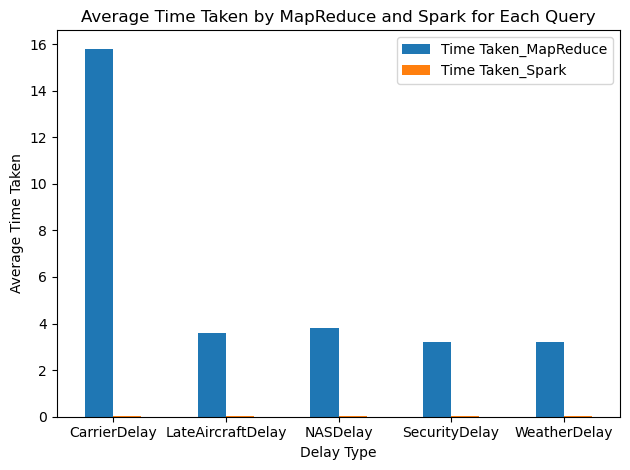

In [35]:
# Plot the graph as a bar graph
avg_df.plot(x='Delay Type', y=['Time Taken_MapReduce', 'Time Taken_Spark'], kind='bar')
plt.title('Average Time Taken by MapReduce and Spark for Each Query')
plt.xlabel('Delay Type')
plt.ylabel('Average Time Taken')
plt.xticks(rotation=0)
plt.tight_layout()

# Save the figure
plt.savefig('average_times_comparison.png')
plt.show()